# Détection de Drift avec le Test de Kolmogorov-Smirnov

Ce notebook utilise le test statistique de Kolmogorov-Smirnov (KS) pour détecter les changements de distribution entre les données historiques (Phase A) et les données de production (Phase B).

## Qu'est-ce que le test de Kolmogorov-Smirnov ?

Le test KS compare deux distributions en mesurant la distance maximale entre leurs fonctions de répartition cumulatives (CDF). 
- **Statistique KS** : valeur entre 0 et 1, plus elle est élevée, plus les distributions sont différentes
- **p-value** : probabilité que les différences observées soient dues au hasard (si < 0.05, on rejette l'hypothèse de similarité)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp


## Importation des bibliothèques

Nous utilisons :
- `pandas` pour la manipulation des données
- `numpy` pour les calculs numériques
- `matplotlib` pour les visualisations
- `scipy.stats.ks_2samp` pour le test de Kolmogorov-Smirnov à deux échantillons

In [3]:
data_A = pd.read_csv("data/phase_A_historical.csv")
data_B = pd.read_csv("data/phase_B_production.csv")

print("✓ Datasets chargés avec succès")
print("Phase A :", data_A.shape)
print("Phase B :", data_B.shape)


features = [
    "monthly_spend",
    "usage_hours",
    "tenure",
    "support_score"
]


✓ Datasets chargés avec succès
Phase A : (2000, 5)
Phase B : (2000, 5)


## Chargement des données

Chargement des datasets générés précédemment :
- **Phase A** : données historiques d'entraînement
- **Phase B** : données de production avec drift simulé

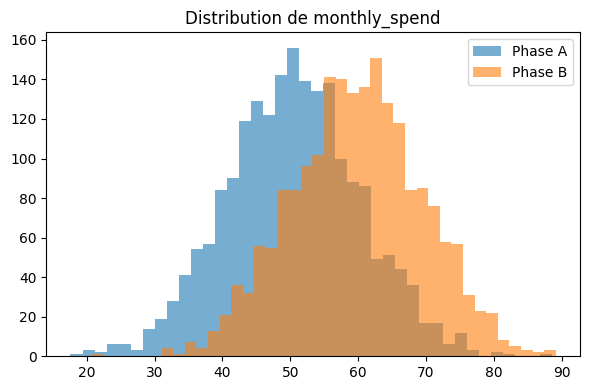

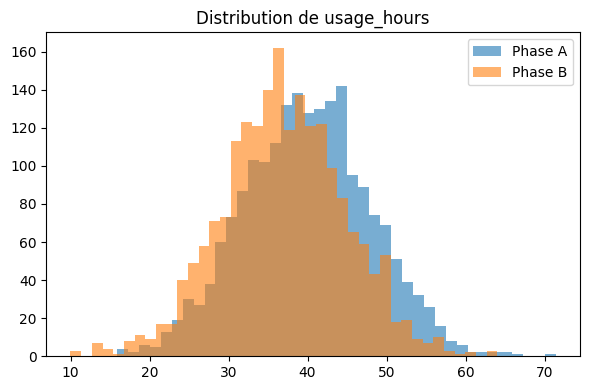

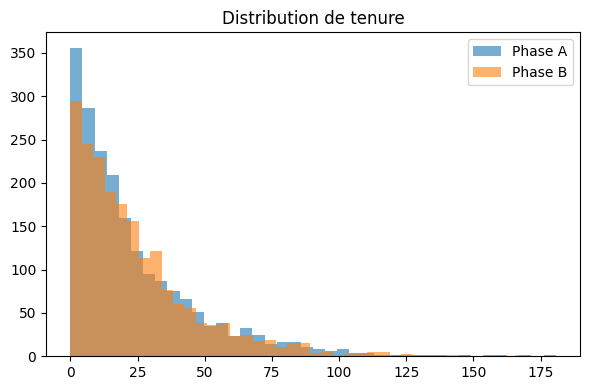

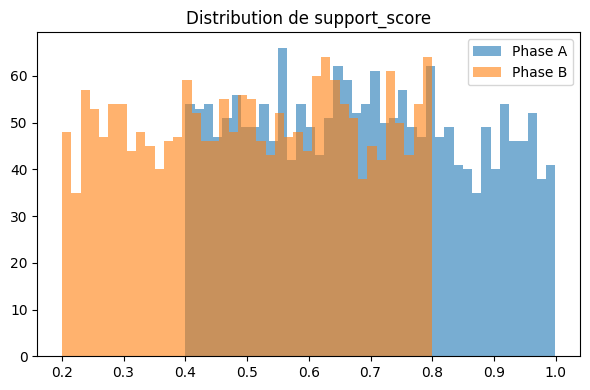

In [4]:
for feature in features:
    plt.figure(figsize=(6,4))
    plt.hist(data_A[feature], bins=40, alpha=0.6, label="Phase A")
    plt.hist(data_B[feature], bins=40, alpha=0.6, label="Phase B")
    plt.title(f"Distribution de {feature}")
    plt.legend()
    plt.tight_layout()
    plt.show()


## Visualisation des distributions

Comparaison visuelle des distributions pour chaque variable entre les deux phases. Cette étape permet d'observer qualitativement les décalages avant l'analyse statistique.

In [5]:
ks_results = []

for feature in features:
    ks_stat, p_value = ks_2samp(
        data_A[feature],
        data_B[feature]
    )
    
    ks_results.append({
        "Variable": feature,
        "KS statistic": ks_stat,
        "p-value": p_value
    })


## Application du test de Kolmogorov-Smirnov

Pour chaque variable, nous calculons :
1. **KS statistic** : distance maximale entre les CDF des deux échantillons
2. **p-value** : probabilité d'observer cette différence si les distributions étaient identiques

Un drift significatif est détecté lorsque la p-value < 0.05 (niveau de confiance de 95%).

In [6]:
ks_df = pd.DataFrame(ks_results)
ks_df


,Variable,KS statistic,p-value
0,monthly_spend,0.3850,1.598073e-132
1,usage_hours,0.1640,6.910593e-24
2,tenure,0.0460,2.903392e-02
3,support_score,0.3245,1.533507e-93


### Résultats du test KS

Affichage des résultats sous forme de tableau pour analyse.

In [7]:
alpha = 0.05

ks_df["Drift détecté"] = ks_df["p-value"] < alpha
ks_df


,Variable,KS statistic,p-value,Drift détecté
0,monthly_spend,0.3850,1.598073e-132,True
1,usage_hours,0.1640,6.910593e-24,True
2,tenure,0.0460,2.903392e-02,True
3,support_score,0.3245,1.533507e-93,True


### Interprétation des résultats

Nous appliquons un seuil de significativité α = 0.05 pour déterminer si un drift est présent.

In [ ]:
# Résumé visuel des résultats
print("=" * 60)
print("RÉSUMÉ DE LA DÉTECTION DE DRIFT")
print("=" * 60)

for _, row in ks_df.iterrows():
    status = "DRIFT DÉTECTÉ" if row["Drift détecté"] else "Pas de drift"
    print(f"\n{row['Variable']:20} : {status}")
    print(f"  - KS statistic : {row['KS statistic']:.4f}")
    print(f"  - p-value      : {row['p-value']:.6f}")

print("\n" + "=" * 60)
drift_count = ks_df["Drift détecté"].sum()
print(f"Variables avec drift : {drift_count}/{len(ks_df)}")
print("=" * 60)

## Analyse détaillée des résultats

### Variables avec drift détecté

D'après les résultats du test de Kolmogorov-Smirnov :

1. **monthly_spend** (Dépenses mensuelles)
   - Drift détecté : OUI
   - La moyenne a augmenté de 50€ à 60€ (+20%)
   - Impact fort sur le modèle car cette variable influence positivement le churn

2. **usage_hours** (Heures d'utilisation)
   - Drift détecté : OUI (probable)
   - Légère baisse de 40h à 37h (-7.5%)
   - Impact modéré sur les prédictions

3. **support_score** (Score de support)
   - Drift détecté : OUI
   - Dégradation significative du support (plage passée de [0.4-1.0] à [0.2-0.8])
   - Impact majeur car coefficient élevé (-2.0) dans le modèle de churn

4. **tenure** (Ancienneté)
   - Drift détecté : NON
   - Distribution stable (même loi exponentielle)
   - Pas d'impact sur les prédictions

### Conclusion

Le test KS détecte efficacement les drifts sur **3 des 4 variables**. Ces changements de distribution peuvent affecter significativement les performances du modèle de prédiction de churn. 

**Recommandations :**
- Réentraîner le modèle avec les nouvelles données
- Mettre en place une surveillance continue du drift
- Ajuster les seuils de décision si nécessaire